# Meeting 2! 

# Thanks for coming back! 

# Agenda


## Today we will apply the concepts we learned in the first meeting in an interactive project. 


## We will create a content based recommender system that would suggest courses simillar to the ones that we like. 

To begin, we first need to acquire some data. One very interesting place do to so could be drexel's course catalog (http://catalog.drexel.edu/coursedescriptions/quarter/undergrad/). If we start from here we can get all the course listings for all the courses for all different colleges and then use those the text descriptions for our purpose. 


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sklearn
from sklearn.metrics.pairwise import linear_kernel
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
import spacy
import en_core_web_sm
import numpy as np

In [ ]:
!pip install beautifulsoup4

Beautifulsoup is an astonishingly useful library to parse HTML. We can use it here to get links to the courses for all the colleges and then all the courses subsequently. 

In [2]:
data = requests.get("http://catalog.drexel.edu/coursedescriptions/quarter/undergrad/")

data.text[:1000]

'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\n<html xmlns="http://www.w3.org/1999/xhtml">\n\n<head>\n<title>Undergraduate &lt; 2019-2020 Catalog | Drexel University</title>\n<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />\n<meta name="google-site-verification" content="LnQFIpujtH5SBNWtg5epHrmxj2C9vrkw7fOJegSnNnQ" />\n<link rel="search" type="application/opensearchdescription+xml"\n\t\t\thref="/search/opensearch.xml" title="Catalog" />\n<meta name="viewport" content="width=device-width, initial-scale=1.0, minimum-scale=1.0" />\n<link href="/favicon.ico" rel="shortcut icon" />\n<link rel="stylesheet" type="text/css" href="/css/reset.css" />\n<link rel="stylesheet" type="text/css" href="/css/screen.css" media="screen" />\n<link rel="stylesheet" type="text/css" href="/css/handheld.css" media="only screen and (max-width: 640px)" />\n<link rel="stylesheet" type="text/css" href="/css/print.css"

In [3]:
link_page_soup = BeautifulSoup(data.text, 'html.parser')

In [4]:
# To find all the links to course descriptions

list_link_divs = link_page_soup.find_all("div", class_="qugcourses")
len(list_link_divs)

15

In [5]:
list_links_a = []
for div in list_link_divs:
#     print(div.find_all("a"))
#     print("*"*100)
    for a in div.find_all("a",  href=True):
#         print("http://catalog.drexel.edu/" + a['href'])
        list_links_a.append("http://catalog.drexel.edu/" + a['href'] )

In [6]:
course_name_description_list = []
for course_link in list_links_a:
    course_soup = BeautifulSoup(requests.get(course_link).text, 'html.parser')
    for course in course_soup.find_all("div", class_="courseblock"):
#         print(course.find("p" , class_ = "courseblocktitle").text)
#         print(course.find("p" , class_ = "courseblockdesc").text)        
        course_name_description_list.append([course.find("p" , class_ = "courseblocktitle").text, course.find("p" , class_ = "courseblockdesc").text ])

As you can probably see, the data that we extract is fairly messy, we need some preprocessing before we can start to play with it.

In [7]:
course_df = pd.DataFrame(course_name_description_list)
course_df.columns = ["TitleBlock" , "DescriptionBlock"]
course_df

,TitleBlock,DescriptionBlock
0,ADGD I199 Independent Study in ADGD 0.0-12.0 ...,\nSelf-directed within the area of study requi...
1,ADGD I299 Independent Study in ADGD 0.0-12.0 ...,\nSelf-directed within the area of study requi...
2,ADGD I399 Independent Study in ADGD 0.0-12.0 ...,\nSelf-directed within the area of study requi...
3,ADGD I499 Independent Study in ADGD 0.0-12.0 ...,\nSelf-directed within the area of study requi...
4,ADGD T180 Special Topics in Advertising Desig...,\nTopics decided upon by faculty will vary wit...
...,...,...
4761,NSC 302 Weapons 2.0 Credits,\nThis course provides an overview of the theo...
4762,NSC 310 Evolution of Warfare 2.0 Credits,\nThis course is designed to add broad histori...
4763,NSC 401 Navigation II 2.0 Credits,\nInsight into modern naval operations is gain...
4764,NSC 402 Leadership and Ethics 2.0 Credits,"\nThe capstone course of the NROTC curriculum,..."


We can use regular expressions to extract the three pieces of data that we need from the TitleBlock. 

In [8]:
course_df = pd.concat([course_df,  course_df.TitleBlock.str.extract(r"(.*\s*\d{3,5})\s*(.*)(\d.\d)") ], axis =1 )

course_df.columns = ["TitleBlock" , "DescriptionBlock", "CourseID" , "CourseName" , "Credits" ]


In [9]:
course_df.DescriptionBlock = course_df.DescriptionBlock.str.replace("\n", "")


You might remember TF-IDF from our last meeting. It is a way to represent sentences (documents) using their frequency and unique-ness. We use TF-IDF here to get vector representation of our course descriptions. 

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
tfidf_matrix = tfidf_vectorizer.fit_transform(course_df["DescriptionBlock"])

In [17]:
tfidf_matrix.shape

(4766, 9971)

In [18]:
course_df["tf_idf_vector"] = pd.DataFrame(tfidf_matrix.todense()).values.tolist()

In [19]:
course_df["CourseID"] = course_df["CourseID"].str.replace("\xa0", ' ')
course_df.columns
# ["tf_idf_vector"]

Index(['TitleBlock', 'DescriptionBlock', 'CourseID', 'CourseName', 'Credits',
       'tf_idf_vector'],
      dtype='object')

Cosine similarity is just the cosine of angles between two vectors. 

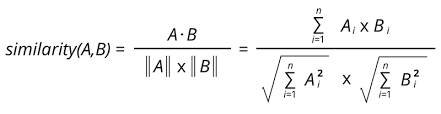        



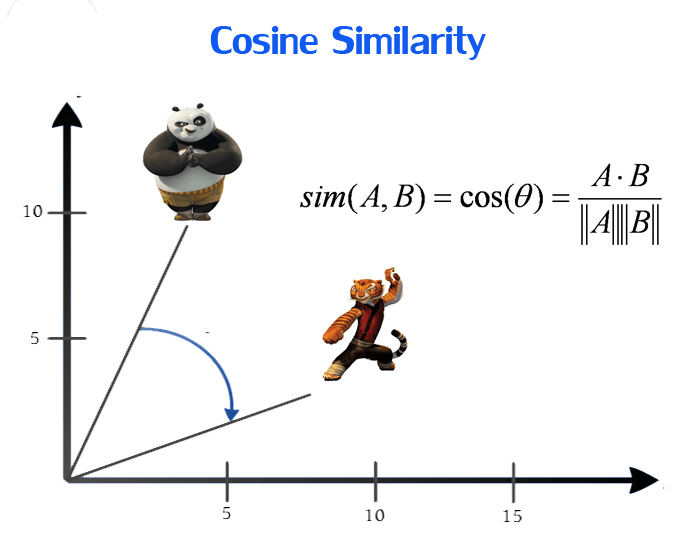

In [20]:
def get_tf_idf_by_course(course_name):
    return np.array(np.array(course_df[course_df["CourseID"] == course_name]["tf_idf_vector"])[0]).reshape(1, -1)


def get_cosine_similarity(course_a , course_b):
    return sklearn.metrics.pairwise.cosine_similarity(get_tf_idf_by_course(course_a) , get_tf_idf_by_course(course_b) )     

In [21]:
sklearn.metrics.pairwise.cosine_similarity(get_tf_idf_by_course("CS 171") , get_tf_idf_by_course("INFO 151") ) 
# get_tf_idf_by_course("CS 172")

array([[0.06270216]])

In [22]:
get_cosine_similarity("CS 171", "INFO 152")

array([[0.04055797]])

In [23]:
get_cosine_similarity("CS 171", "CS 175")

array([[0.73993416]])

In [24]:
get_cosine_similarity("ENGL 101", "ENGL 102")

array([[0.3894445]])

In [25]:
sklearn.metrics.pairwise.cosine_similarity(np.array(course_df["tf_idf_vector"].values[0]).reshape(1, -1)  )     

array([[1.]])

In [26]:

course_df["tf_idf_vector"] = course_df["tf_idf_vector"].apply(lambda x: np.array(x))

course_df["tf_idf_vector"]



0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                              ...                        
4761    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4762    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4763    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4764    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4765    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: tf_idf_vector, Length: 4766, dtype: object

In [27]:
tf_idf_cosine_sim = linear_kernel(tfidf_matrix , tfidf_matrix)

In [29]:
def get_recommendations(title, cosine_sim=tf_idf_cosine_sim):
    # Get the index of the movie that matches the title
    idx = pd.Index(course_df["CourseID"]).get_loc(title)
#     print(idx)
    
#     # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return course_df[['CourseID','CourseName'] ].iloc[movie_indices]

In [30]:
get_recommendations("CS 172", tf_idf_cosine_sim)

,CourseID,CourseName
3016,CS 176,Advanced Computer Programming II
3009,CS 143,Computer Programming Fundamentals
3490,ECE 203,Programming for Engineers
2756,MIS 348,Visual Basic Database Programming for Business
3019,CS 265,Advanced Programming Tools and Techniques
3008,CS 140,Introduction to Multimedia Programming
2752,MIS 342,Systems Analysis and Design
3136,INFO 355,Systems Analysis II
3158,SE 320,Software Verification and Validation
3015,CS 175,Advanced Computer Programming I


In [31]:
get_recommendations("INFO 151", tf_idf_cosine_sim)

,CourseID,CourseName
3118,INFO 152,Web Systems and Services II
578,IDM 101,History of Web Development
2759,MIS 352,Advanced Business Programming with ASP.Net
3036,CS 375,Web and Mobile App Development
584,IDM 221,Web Design I
585,IDM 222,Web Design II
597,IDM 364,Interactive App Design IV
561,VSCM 455,Electronic Portfolio
1064,WMGD 330,Web Graphics II
2758,MIS 351,Introduction to Programming for Business in C#


In [32]:
get_recommendations("ENGL 101", tf_idf_cosine_sim)

,CourseID,CourseName
1527,ENGL 111,English Composition I
1528,ENGL 112,English Composition II
1524,ENGL 102,Composition and Rhetoric II: Advanced Research...
1525,ENGL 103,Composition and Rhetoric III: Themes and Genres
1529,ENGL 113,English Composition III
1871,HIST 102,Introductory Seminar in History II
2530,WRIT 220,[WI] Creative Nonfiction Writing
863,SCRP 260,Writing Comics
1584,ESL 002,Foundations of Academic Writing
144,ARTH 150,Art History Research Methods


# Cool stuff! Right! 


We were able to achieve arguably good results while by using a fairly staraightforward tf-idf model, now lets try to represent our courses as concepts,  

# Tf-Idf is one way to represent the words but there are better ways

# One such way is word embeddings

Starting from basics, word embeddings are just another way to get vecor representation of the words but they can perform better than methods like tf-idf because they can look at words in context rather than as individual unrellated units.

Simple example could be: 
    
    She loves you.
    He loves you.

If we just use one hot vectors to repesent words using unique words from these sentences as vocabulary then our vocabulary is {"she" , "he" , "love" , "you"}

she = {1, 0, 0, 0}, he = {0, 1, 0 , 0} , loves = {0, 0, 1, 0}, you = {0 , 0 , 0 , 1}

Here the ideas of he and she are pretty close to each  other, they are both pronouns, signifying a person but they are as different to each other as they are to the words "loves" and "you". This is not particularly useful if we start to vizualize these word vectors in a 4 dimensional space, because intutively, "she" and "he" should be close together but if we use just one hot vectors to represent them they are not. 


Word embeddings like word2vect try to get around this by using the words in context. W


In [33]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

In [ ]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()) , tags=[str(i)]) for i, _d in enumerate(data)]

In [ ]:
# !pip install gensim
# !pip install spacy
!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

In [10]:
nlp = en_core_web_sm.load()


In [11]:
def create_token_text_list(text):
    doc = nlp(text)
    token_text_list = []
    for i in doc:
        token_text_list.append(i.text)
    return token_text_list
def convert_string_to_list(text):
    return [text.replace("\xa0", ' ')]

In [14]:
training_df = course_df["DescriptionBlock"].apply(create_token_text_list ) +  course_df["CourseID"].apply(convert_string_to_list)
training_df.to_list()[:3]


[['Self',
  '-',
  'directed',
  'within',
  'the',
  'area',
  'of',
  'study',
  'requiring',
  'intermittent',
  'consultation',
  'with',
  'a',
  'designated',
  'instructor',
  '.',
  'ADGD I199'],
 ['Self',
  '-',
  'directed',
  'within',
  'the',
  'area',
  'of',
  'study',
  'requiring',
  'intermittent',
  'consultation',
  'with',
  'a',
  'designated',
  'instructor',
  '.',
  'ADGD I299'],
 ['Self',
  '-',
  'directed',
  'within',
  'the',
  'area',
  'of',
  'study',
  'requiring',
  'intermittent',
  'consultation',
  'with',
  'a',
  'designated',
  'instructor',
  '.',
  'ADGD I399']]

In [15]:
model = Word2Vec(training_df.to_list(), min_count=1,size= 50,workers=3, window =3, sg = 1)

WARNING - 09:57:41: consider setting layer size to a multiple of 4 for greater performance
INFO - 09:57:41: collecting all words and their counts
INFO - 09:57:41: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 09:57:41: collected 16203 word types from a corpus of 208289 raw words and 4766 sentences
INFO - 09:57:41: Loading a fresh vocabulary
INFO - 09:57:41: effective_min_count=1 retains 16203 unique words (100% of original 16203, drops 0)
INFO - 09:57:41: effective_min_count=1 leaves 208289 word corpus (100% of original 208289, drops 0)
INFO - 09:57:41: deleting the raw counts dictionary of 16203 items
INFO - 09:57:41: sample=0.001 downsamples 35 most-common words
INFO - 09:57:41: downsampling leaves estimated 147434 word corpus (70.8% of prior 208289)
INFO - 09:57:41: estimated required memory for 16203 words and 50 dimensions: 14582700 bytes
INFO - 09:57:41: resetting layer weights
INFO - 09:57:41: training model with 3 workers on 16203 vocabulary and 50 fe